Tristan J. Hillis <br/>
ID: 1260315 <br/>
Astro 425 | Homework # 4 Part 2

# Problem 3: Gravitational Point Mass Lensing
The first class is used to generate an image with a 2d gaussian acting as a source.

The second class is the gravitational point mass lensing class.

Look below the these classes for the two parts we are assinged.

In [18]:
%pylab inline

# Other imports
from scipy.integrate import quad
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits

# style changes
#import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10.0, 8.0)
mpl.rc('lines', linewidth=1.8, color='k')
mpl.rcParams['font.size'] = 14

def ticks(labelsize, major_size, minor_size):
    mpl.rc('xtick', labelsize=labelsize)
    mpl.rc('xtick.major', size=major_size)
    mpl.rc('xtick.minor', size=minor_size)
    mpl.rc('ytick', labelsize=labelsize)
    mpl.rc('ytick.major', size=major_size)
    mpl.rc('ytick.minor', size=minor_size)
    
ticks(15, 10.0, 5)

Populating the interactive namespace from numpy and matplotlib


In [3]:
class GenerateGaussIm():

    def __init__(self, center, dev, imSize):
        """
        Pre: Takes in x and y center as tuple (x, y) as well as deviations as tuple, (d_x, d_y).
        The image size is also givin and it will be symmetric
        Post: Assigns the center and deviations to global variables as well as generate the image
        and assigns it as the global variable self.im.  To access the image one uses objectVariable.im .
        """
        self.mu_x = center[0]
        self.mu_y = center[1]

        self.sigma_x = dev[0]
        self.sigma_y = dev[1]

        self._x = np.linspace(-10, 10, imSize)
        self._y = np.linspace(-10, 10, imSize)

        self._X, self._Y = np.meshgrid(self._x, self._y)
        self.im = self._gauss2d()



    def _gauss2d(self):
        """
        Pre: No user input.
        Post: Returns a two dimensional Gaussian.
        """
        norm = 1.0 / (2 * np.pi * self.sigma_x * self.sigma_y)
        exp = np.exp(-((self._X - self.mu_x)**2.0 / (2.0*self.sigma_x**2.0) + (self._Y - self.mu_y)**2.0 / (2.0*self.sigma_y**2.0)))
        return norm * exp

    def changeLoc(self, center):
        """
        Pre: Takes in new center coordinates as a tuple, i.e. (x, y).
        Post: Changes the objects image, self.im to the changed image.
        """
        self.mu_x = center[0]
        self.mu_y = center[1]
        self.im = self._gauss2d()

    def changeSize(self, dev):
        """
        Pre: Takes in new deviations as a tuple, i.e. (sigma_x, sigma_y).
        Post: Updates the object's image, self.im to the new image.
        """
        self.sigma_x = dev[0]
        self.sigma_y = dev[1]
        self.im = self._gauss2d()

    def changeLocSize(self, center, dev):
        """
        Pre: Takes in new center coordinates as a tuple, i.e. (x, y), as well as a new deviation
        as a tuple, i.e. (sigma_x, sigma_y).
        Post: Updates the objects image, self.im to the new image.
        """
        self.mu_x = center[0]
        self.mu_y = center[1]
        self.sigma_x = dev[0]
        self.sigma_y = dev[1]
        self.im = self._gauss2d()

In [4]:
class GravLens():

    def __init__(self, image, D_l, D_ls, D_s, M, FOV):
        """
        Pre: Takes in a symmetrical image (needs to be numpy array), the distances to the lens, lens to source, and source
        in Mpc, takes in the mass of the lens in solar mass, and the field-of-view of the image.
        Post: Initializes several global variables for use in the methods below.
        """

        self.D_l = self._makeMeters(D_l)
        self.D_ls = self._makeMeters(D_ls)
        self.D_s = self._makeMeters(D_s)
        self.M = self._makeKg(M)
        self.FOV = np.radians(1.0 * FOV / image.shape[0] / 60) # now in units of rad / pixel

        self._theta_e = self._getThetaEinstein()

        # various image attributes
        self._im_h = image.shape[0] # image height
        self._im_w = image.shape[1] # image width
        self._im_c = np.array([self._im_h / 2.0, self._im_w / 2.0]) # image center or lens location

        self.iniImage = image
        self.newIm = np.zeros(image.shape[0] * image.shape[1]) # new image to be filled; a 1D array


    def lensImage(self):
        """
        Pre: No user input
        Post: Lenses the initial input image and stores it in the global variable self.newIm.
        """
        flat_image = self.iniImage.ravel()
        for i in range(int(self._im_h)):

            for j in range(int(self._im_w)):
                if i is not int(self._im_h * self._im_c[0] + self._im_c[1]):
                    current_pixel = flat_image[self._im_h * i + j]

                    current_pixel_pos = np.array([i, j])

                    current_sep = self._seperation(current_pixel_pos)
                    current_beta = self._getAngle(current_sep) # directly from image based on scale
                    current_thetas = self._thetaLensEq(current_beta)


                    new_sep = self._getSep(current_thetas)
                    newCoords_plus, newCoords_minus = self._getCoords_Theta(current_pixel_pos, current_sep, new_sep)

                    # round new Coords and translate to real pixel values
                    newCoords_plus = self._roundCoords(newCoords_plus)
                    newCoords_minus = self._roundCoords(newCoords_minus)

                    newCoords_flat_plus = self._im_h * newCoords_plus[0] + newCoords_plus[1]
                    newCoords_flat_minus = self._im_h * newCoords_minus[0] + newCoords_minus[1]


                    if(newCoords_flat_plus < flat_image.size and newCoords_flat_plus >= 0):
                        self.newIm[int(newCoords_flat_plus)] += current_pixel
                    if(newCoords_flat_minus < flat_image.size and newCoords_flat_minus >= 0):
                        self.newIm[int(newCoords_flat_minus)] += current_pixel

        self.newIm = self.newIm.reshape(self.iniImage.shape)

    def unlens(self, lensImage):
        """
        Note: This is the would be method for unlensing the image.  Possiblely implemented in
        the future.
        Pre:
        Post:

        """
        print "This function has not been built up for use yet."

    def interpolation(self, image, type='linear'):
        """
        Pre: Takes in an image to run interpolation over, default and only one is linear.
        Post: Returns a linearly interpolated image.
        """


        height = image.shape[0] # first indice in .shape is height of matrix
        width = image.shape[1] # second indice in .shape is width of matrix

        flat_image = np.copy(image.ravel())

        for i in range(flat_image.size):
            grid = []
            if(i % self._im_w == 0): # at the right edge of image
                grid.append(i - self._im_w) # upper value
                grid.append(i - self._im_w + 1) # grid upper right value
                grid.append(i + 1) # mid right value
                grid.append(i + self._im_w) # below value
                grid.append(i + self._im_w + 1) # below right value
            elif(i % self._im_w == self._im_h): # at the left edge of image
                grid.append(i - self._im_w) # upper value
                grid.append(i - self._im_w - 1) # grid upper left value
                grid.append(i - 1) # mid left value
                grid.append(i + self._im_w) # below value
                grid.append(i + self._im_w - 1) # below left value
            else:
                grid.append(i - self._im_w) # upper value
                grid.append(i - self._im_w + 1) # upper right value
                grid.append(i - self._im_w - 1) # grid upper left value
                grid.append(i + 1) # mid right value
                grid.append(i - 1) # mid left value
                grid.append(i + self._im_w) # below value
                grid.append(i + self._im_w + 1) # below right value
                grid.append(i + self._im_w - 1) # below left value
            grid = np.asarray(grid)
            grid = grid[grid >= 0] # filter indices less than zero
            grid = grid[grid < flat_image.size] # filter indices greater than flat image size
            sum = 0
            for j in grid:
                value = flat_image[j]
                sum += value
            average = 1.0 * sum / grid.size
            flat_image[i] += average
        return flat_image.reshape(self._im_h, self._im_w)

    def getEinsteinRing(self):
        """
        Pre: No user input.
        Post: Returns the plot variables capable of plotting the einstein ring.  Also it returns
        the grid on which the einstein ring will be plotted on.
        """
        circle = np.linspace(0, 2*np.pi, 100)
        x_polar = self._theta_e * np.cos(circle)
        y_polar = self._theta_e * np.sin(circle)
        x_theta_e = np.linspace(-self._im_c[1], self._im_c[1], self._im_w) * self.FOV
        y_theta_e = np.linspace(-self._im_c[0], self._im_c[0], self._im_h) * self.FOV
        X_theta_e, Y_theta_e = np.meshgrid(x_theta_e, y_theta_e)

        plotVars = [x_polar, y_polar]
        grid = [X_theta_e, Y_theta_e]

        return [plotVars, grid]

    def _getCoords_Theta(self, coords, oldSep, newSep):
        """
        Pre: Takes in a set of pixel coordinates, the initial pixel coordinate seperation, and
        the new theta pixel seperation (there are two new seps. for each theta), respectively.
        Post: Returns the theta_plus and theta_minus pixel coordinates based on the set of circumstances.
        """
        # treat theta+_sep, i.e. newSep[0].  This will go outwards from the original beta angle ALWAYS.
        theta_plus_coords = np.array([0.0, 0.0])
        scale_plus = 1.0 * newSep[0] / oldSep
        # x-axis for theta_plus
        if(coords[0] <= self._im_c[0]):
            dif_x = self._im_c[0] - coords[0]
            dif_x = dif_x * scale_plus - dif_x
            theta_plus_coords[0] = coords[0] - dif_x
        else:
            dif_x = coords[0] - self._im_c[0]
            dif_x = dif_x * scale_plus - dif_x
            theta_plus_coords[0] = coords[0] + dif_x
        # y-axis for theta_plus
        if(coords[1] <= self._im_c[1]):
            dif_y = self._im_c[1] - coords[1]
            dif_y = dif_y * scale_plus - dif_y
            theta_plus_coords[1] = coords[1] - dif_y
        else:
            dif_y = coords[1] - self._im_c[1]
            dif_y = dif_y * scale_plus - dif_y
            theta_plus_coords[1] = coords[1] + dif_y

        # treat theta-_sep, i.e. newSep[1].  This will go inwards from the original angle and be inside the einstein ring.
        # If negative then it is on other side of the lens past the center pixel.
        theta_minus_coords = np.array([0.0, 0.0])
        scale_minus = 0
        if newSep[1] >= 0:
            scale_minus = 1.0 * newSep[1] / oldSep
        else:
            scale_minus = (-1.0 * newSep[1] + oldSep) / oldSep
        # x-axis for theta_minus
        if(coords[0] <= self._im_c[0]):
            dif_x = self._im_c[0] - coords[0]
            if scale_minus <= 1.0:
                dif_x = dif_x - dif_x * scale_minus
            else:
                dif_x = dif_x * scale_minus
            theta_minus_coords[0] = coords[0] + dif_x
        else:
            dif_x = coords[0] - self._im_c[0]
            if scale_minus <= 1.0:
                dif_x = dif_x - dif_x * scale_minus
            else:
                dif_x = dif_x * scale_minus
            theta_minus_coords[0] = coords[0] - dif_x
        # y-axis for theta_minus
        if(coords[1] <= self._im_c[1]):
            dif_y = self._im_c[1] - coords[1]
            if scale_minus <= 1.0:
                dif_y = dif_y - dif_y * scale_minus
            else:
                dif_y = dif_y * scale_minus
            theta_minus_coords[1] = coords[1] + dif_y
        else:
            dif_y = coords[1] - self._im_c[1]
            if scale_minus <= 1.0:
                dif_y = dif_y - dif_y * scale_minus
            else:
                dif_y = dif_y * scale_minus
            theta_minus_coords[1] = coords[1] - dif_y

        return [theta_plus_coords, theta_minus_coords]

    def _getCoords_Beta(self, coords, oldSep, newSep):
        """
        Note: Untested method for calculating beta for the would be unlensing method
        Pre: Takes in the inital pixel coordinates, that coordinates seperation about the
        center of the image in pixels, and the new pixel seperation due to the lens.
        Post: Returns the new pixel coordinates of the beta angle due to the lensing.  Similar
        to calculating theta plus except the new coordinate would be inward rather than outwards.
        """
        if newSep >= 0:
            scale = 1.0 * newSep / oldSep
        else:
            scale = (-1.0 * newSep + oldSep) / oldSep

        #scale = 1.0 * newSep / oldSep
        dif_x = 0
        dif_y = 0
        newCoord_x = 0
        newCoord_y = 0

        # deals with x-axis
        if(coords[0] <= self._im_c[0]):
            dif_x = self._im_c[0] - coords[0]
            if scale <= 1.0:
                dif_x_sep = dif_x - dif_x * scale
            else:
                dif_x_sep = dif_x + dif_x * scale
            newCoord_x = coords[0] + dif_x_sep
        else:
            dif_x = coords[0] - self._im_c[0]
            if scale <= 1.0:
                dif_x_sep = dif_x - dif_x * scale
            else:
                dif_x_sep = dif_x + dif_x * scale
            newCoord_x = coords[0] - dif_x_sep

        # deals with y-axis
        if(coords[1] <= self._im_c[1]):
            dif_y = self._im_c[1] - coords[1]
            if scale <= 1.0:
                dif_y_sep = dif_y - dif_y * scale
            else:
                dif_y_sep = dif_y + dif_y * scale
            newCoord_y = coords[1] + dif_y_sep
        else:
            dif_y = coords[1] - self._im_c[1]
            if scale <= 1.0:
                dif_y_sep = dif_y - dif_y * scale
            else:
                dif_y_sep = dif_y + dif_y * scale
            newCoord_y = coords[1] - dif_y_sep

        return np.array([newCoord_x, newCoord_y])


    def _seperation(self, coords):
        """
        Pre: Take in pixel coordinates as (x, y) on the image.
        Post: Calculates the seperation of the coordinates respective to the x and y axis and
        returns that pixel seperation using the Pythagorean Theorem.
        """
        dif_x = 0
        dif_y = 0
        if(coords[0] <= self._im_c[0]):
            dif_x = self._im_c[0] - coords[0]
        else:
            dif_x = coords[0] - self._im_c[0]

        if(coords[1] <= self._im_c[1]):
            dif_y = self._im_c[1] - coords[1]
        else:
            dif_y = coords[1] - self._im_c[1]

        return np.sqrt(dif_x ** 2.0 + dif_y ** 2.0)


    def _beta(self, theta):
        """
        Pre: Takes in the lensing angle theta in radians.
        Post: Returns the lensing angle beta from the point mass lens equation in radians.
        """
        return theta - self.theta_e**2.0 / theta

    def _thetaLensEq(self, beta):
        """
        Pre: Takes in the lensing angle beta in radians.
        Post: Returns the two theta solutions to the lens equation, theta plus and minus.
        """
        theta_1 = (1.0 / 2) * (beta + np.sqrt(beta**2.0 + 4*self._theta_e**2.0))
        theta_2 = (1.0 / 2) * (beta - np.sqrt(beta**2.0 + 4*self._theta_e**2.0))
        return np.array([theta_1, theta_2])

    def _getAngle(self, sep):
        """
        Pre: Takes in a pixel seperation.
        Post: Returns the pixel seperation to a radian seperation based on the images FOV.
        """
        return 1.0 * sep * self.FOV

    def _getSep(self, angle):
        """
        Pre: Takes in an angle seperation in units of radians.
        Post: Returns the angle seperation in units of pixels based on the image's FOV.
        """
        return 1.0 * angle / self.FOV

    def _getThetaEinstein(self):
        """
        Pre: No user input.
        Post: Returns the angle of the einstein ring's occurence in radians.
        """
        c = 299792458.0 # speed of light m/s
        G = 6.67408e-11 # Newton's gravitational constant

        return np.sqrt((self.D_ls/(self.D_l*self.D_s)) * (4*G*self.M/c**2.0))

    def _makeMeters(self, distance):
        """
        Pre: Take in a distance of mega-parsecs, Mpc.
        Post: Returns distance as meters. (3.086e22 meters per Mpc)
        """
        return distance * 3.086e22

    def _makeKg(self, mass):
        """
        Pre: Takes in some mass in units of solar masses.
        Post: Returns the same mass in units of kg. (2e30 kg per solar_mass)
        """
        return mass * 2.0e30

    def _roundCoords(self, coords):
        """
        Pre: Takes in pixel coordinates.
        Post: Returns the pixel coordinates rounded to the nearest first place.
        """
        return np.round(coords)

# Part a
We are tasked here to produced a lens image where the source is directly behind the lens.  The following code and plots below represent that process.

The lens attributes I use are $D_l = 50 Mpc$, $D_{ls} = 50 Mpc$, an $FOV=5'$ across the image, and $D_s = 100 Mpc$ with a mass of $M = 10^{14}$ about the mass of the Coma Cluster.  I also make a mental note that, in actuallity, $D_l + D_{ls} \neq D_s$ for they are angular diameter distances in actuallity but we don't care about that fact considering the exercise we were tasked with.

The below figures represent lensing with the source behind the point mass.  The first image is the original source image, the second is the raw lensed image contrasted to make things easier to see, and lastly is an interpolated lensed image contrasted to make things easier to see.  The Einstein ring for this case, that is explained above, is plotted in all three figures in blue.



In [43]:
# generate image
image = GenerateGaussIm((0.0, 0.0), (0.5, 0.5), 500)

lens = GravLens(image.im, 50, 50, 100, 10**14.0, 5)
lens.lensImage()
interp = lens.interpolation(lens.newIm)

einVar, einGrid = lens.getEinsteinRing()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:146: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:150: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:159: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:173: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:180: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:195: RuntimeWarning: invalid value encountered in double_scalars


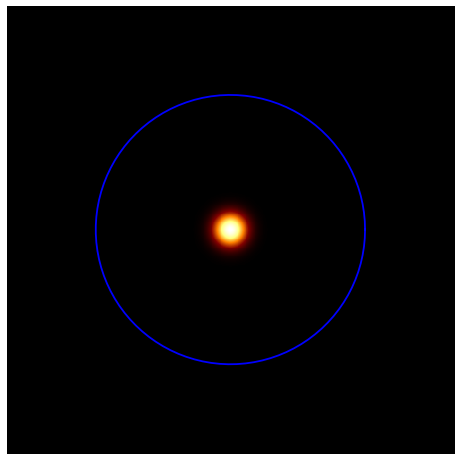

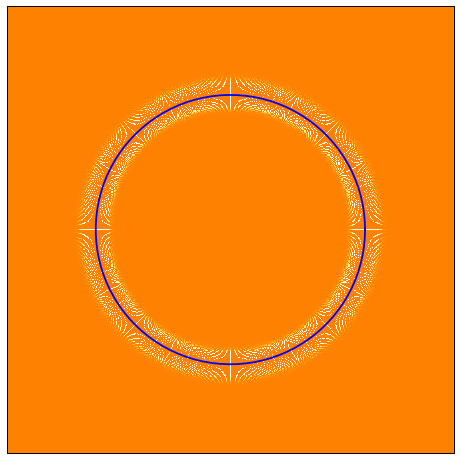

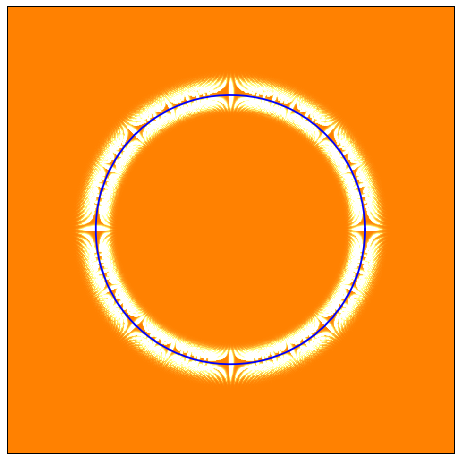

In [44]:
median = np.median(lens.newIm)

# source image
fig, ax = plt.subplots(1,1)
ax.pcolormesh(einGrid[0], einGrid[1], image.im, cmap='afmhot')
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# lensed image; contrast is changed to make easier to see
fig, ax = plt.subplots(1,1)
ax.pcolormesh(einGrid[0], einGrid[1], lens.newIm, cmap='afmhot', vmin=median-0.1, vmax=median+0.1)
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# interpolated lensed image; contrast is changed to make easier to see
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(einGrid[0], einGrid[1], interp, cmap='afmhot', vmin=median-0.1, vmax=median+0.1) 
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



# Part b
We are tasked here to produce a lensed image where the source is near the edge of the Einstein ring.  The following code and plots below represent that process.


The lens attributes I use are $D_l = 50 Mpc$, $D_{ls} = 50 Mpc$, an $FOV=5'$ across the image, and $D_s = 100 Mpc$ with a mass of $M = 10^{14}$ about the mass of the Coma Cluster.  I also make a mental note that, in actuallity, $D_l + D_{ls} \neq D_s$ for they are angular diameter distances in actuallity but we don't care, about that fact considering the exercise we were tasked with.

The below figures represent lensing with the source just within the Einstein ring.  The first image is the original source image, the second is the raw lensed image contrasted to make things easier to see, and lastly is an interpolated lensed image contrasted to make things easier to see.  The Einstein ring for this case that is explained above is plotted in all three figures in blue.

In [45]:
# generate image
image = GenerateGaussIm((3.5, 3.5), (0.5, 0.5), 500)

lens = GravLens(image.im, 50, 50, 100, 10**14.0, 5)
lens.lensImage()
interp = lens.interpolation(lens.newIm)

einVar, einGrid = lens.getEinsteinRing()

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:146: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:150: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:159: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:173: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:180: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:195: RuntimeWarning: invalid value encountered in double_scalars


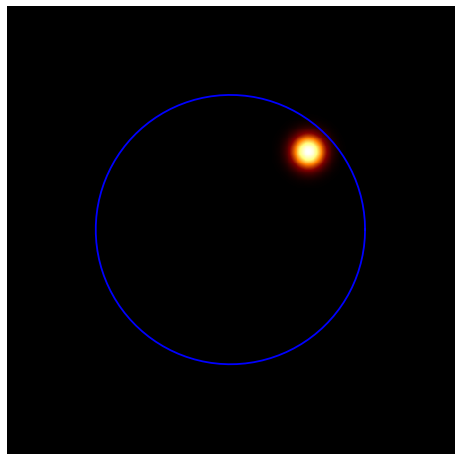

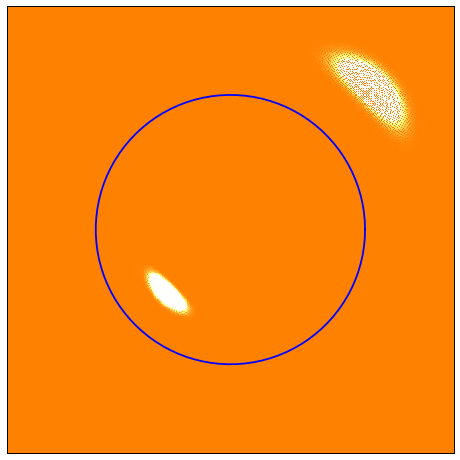

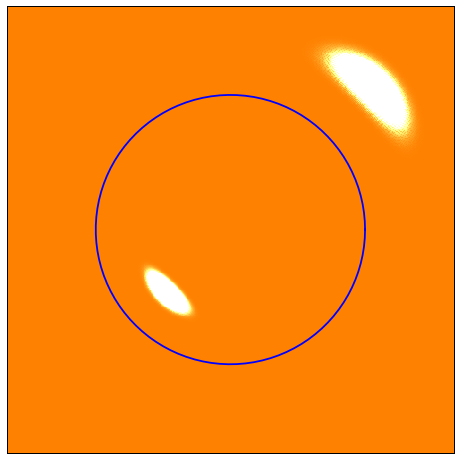

In [46]:
median = np.median(lens.newIm)

# source image
fig, ax = plt.subplots(1,1)
ax.pcolormesh(einGrid[0], einGrid[1], image.im, cmap='afmhot')
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# lensed image; contrast is changed to make easier to see
fig, ax = plt.subplots(1,1)
ax.pcolormesh(einGrid[0], einGrid[1], lens.newIm, cmap='afmhot', vmin=median-0.1, vmax=median+0.1)
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# interpolated lensed image; contrast is changed to make easier to see
fig, ax = plt.subplots(1, 1)
ax.pcolormesh(einGrid[0], einGrid[1], interp, cmap='afmhot', vmin=median-0.1, vmax=median+0.1) 
ax.plot(einVar[0], einVar[1])
ax.axis('image')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


# After Thoughts
Overall this was a fun assignement even though it took me awhile to reliabely fix all the bug I had.  There are some glaring parts with the code namely the _getCoord_Theta and _getCoords_Beta methods that could use some factoring of the if statements, but for now the dirty code works.  

There is also some heavy artifacting in the case where the source is lined up with the lens.  Either this is due to a small bug or more likely because I round to the nearest pixel in my actual lensing.  A fix would then be to doll out the pixel values by area in the surrounding nearby pixels.  That said, my interpolation method is very successful when the source is not being stretched so thin.

There is a good chance I will continue to develop this code in the future for fun, wherein the main goal would be to cut the computation time down by either parallelizing the code, using C-types, or a mixture of both.  Contiguous flattened arrays are also a must anywhere possible to to cut down the CPU overhead time of copying from the system memory to the L1 cache.

